# GWAS Subtype Analysis

This notebook performs unsupervised clustering analysis on GWAS summary statistics to identify potential genetic subtypes.

## Setup
First, install required packages if you haven't already:
```bash
pip3 install hdbscan umap-learn scikit-learn pandas numpy matplotlib scipy
```

In [4]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [5]:
class GWASSubtypeDiscovery:
    def __init__(self, gwas_summary_stats):
        self.gwas_data = gwas_summary_stats
        self.clusters = None
        
    def preprocess_gwas(self):
        # Cap the -log10(p) values to avoid infinities
        min_p = 1e-300
        capped_p = np.maximum(self.gwas_data['P'], min_p)
        
        features = pd.DataFrame({
            'beta': self.gwas_data['BETA'],
            'log_p': -np.log10(capped_p),
            'z_score': self.gwas_data['BETA'] / self.gwas_data['SE'],
            'maf': self.gwas_data.get('MAF', None),
        })
        
        # Handle missing values and infinities
        features = features.replace([np.inf, -np.inf], np.nan)
        features = features.fillna(features.mean())
        
        # Additional check for finite values
        assert np.all(np.isfinite(features.values)), "Data contains non-finite values after preprocessing"
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)
        
        # Dimensionality reduction with PCA
        pca = PCA(n_components=0.95)
        X_reduced = pca.fit_transform(X_scaled)
        
        self.processed_data = X_reduced
        self.pca = pca
        self.feature_names = features.columns
        
        return X_reduced
        
    def discover_subtypes(self, min_cluster_size=1000):
        # Apply UMAP with modified parameters
        umap_reducer = umap.UMAP(
            n_neighbors=50,
            min_dist=0.2,
            n_components=2,
            random_state=42,
            metric='euclidean',
            n_jobs=-1  # Use all CPU cores
        )
        X_umap = umap_reducer.fit_transform(self.processed_data)
        
        # Apply HDBSCAN with stricter parameters
        clusterer = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=20,
            metric='euclidean',
            cluster_selection_method='eom',
            cluster_selection_epsilon=0.7,
            core_dist_n_jobs=-1  # Use all CPU cores
        )
        
        self.clusters = clusterer.fit_predict(X_umap)
        self.clusterer = clusterer
        self.umap_embedding = X_umap
        
        return {
            'cluster_labels': self.clusters,
            'n_clusters': len(set(self.clusters)) - (1 if -1 in self.clusters else 0),
            'cluster_probabilities': clusterer.probabilities_,
            'cluster_sizes': pd.Series(self.clusters).value_counts()
        }
    
    
    def analyze_genetic_patterns(self):
        results = {}
        
        for cluster_id in set(self.clusters):
            if cluster_id != -1:  # Exclude noise points
                cluster_mask = self.clusters == cluster_id
                
                cluster_variants = pd.DataFrame({
                    'SNP': self.gwas_data['SNP'][cluster_mask],
                    'BETA': self.gwas_data['BETA'][cluster_mask],
                    'P': self.gwas_data['P'][cluster_mask]
                })
                
                top_variants = cluster_variants.sort_values('P').head(10)
                
                results[f'cluster_{cluster_id}'] = {
                    'size': sum(cluster_mask),
                    'top_variants': top_variants,
                    'mean_effect_size': np.mean(abs(self.gwas_data['BETA'][cluster_mask])),
                    'min_p_value': cluster_variants['P'].min()
                }
        
        return results
    
    def plot_subtypes(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # UMAP plot
        scatter = ax1.scatter(
            self.umap_embedding[:, 0],
            self.umap_embedding[:, 1],
            c=self.clusters,
            cmap='Spectral',
            s=50,
            alpha=0.5
        )
        ax1.set_title('Genetic Subtypes (UMAP)')
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')
        
        # Manhattan-style plot
        ax2.scatter(
            range(len(self.gwas_data)),
            -np.log10(self.gwas_data['P']),
            c=self.clusters,
            cmap='Spectral',
            s=20,
            alpha=0.5
        )
        ax2.set_title('Variants by Cluster')
        ax2.set_xlabel('Variant Index')
        ax2.set_ylabel('-log10(P)')
        
        plt.colorbar(scatter, ax=ax1, label='Cluster')
        plt.tight_layout()
        
        return fig

## Run Analysis

In [6]:
# Load the simulated data
gwas_data = pd.read_csv("simulated_gwas.csv")
print("Loaded GWAS data shape:", gwas_data.shape)

Loaded GWAS data shape: (100000, 17)


In [7]:
# Initialize and run analysis
discoverer = GWASSubtypeDiscovery(gwas_data)

# Preprocess GWAS data
print("Preprocessing GWAS data...")
discoverer.preprocess_gwas()

# Discover subtypes
print("Discovering subtypes...")
clustering_results = discoverer.discover_subtypes()

# Print initial results
print(f"Discovered {clustering_results['n_clusters']} subtypes")
print("Cluster sizes:")
print(clustering_results['cluster_sizes'])

Preprocessing GWAS data...
Discovering subtypes...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Discovered 2 subtypes
Cluster sizes:
 1    71041
 0    24424
-1     4535
Name: count, dtype: int64


In [8]:
# Analyze patterns
print("Analyzing genetic patterns...")
genetic_patterns = discoverer.analyze_genetic_patterns()

# Print results for each cluster
for cluster_id, patterns in genetic_patterns.items():
    print(f"{cluster_id}:")
    print(f"Size: {patterns['size']}")
    print(f"Mean effect size: {patterns['mean_effect_size']:.4f}")
    print(f"Minimum p-value: {patterns['min_p_value']:.2e}")
    print("Top 5 variants:")
    print(patterns['top_variants'].head())

Analyzing genetic patterns...
cluster_0:
Size: 24424
Mean effect size: 0.0007
Minimum p-value: 1.00e-300
Top 5 variants:
           SNP      BETA              P
54778  rs71638 -0.220982  1.000000e-300
39431  rs54716 -0.272560  1.000000e-300
7982   rs23741 -0.443785  1.000000e-300
79708  rs36457 -0.191337  1.000000e-300
2034    rs4206 -0.241813  1.000000e-300
cluster_1:
Size: 71041
Mean effect size: 0.0006
Minimum p-value: 1.00e-300
Top 5 variants:
           SNP      BETA              P
74305  rs12285  0.246904  1.000000e-300
33348  rs62798  0.206171  1.000000e-300
40578  rs97187  0.209060  1.000000e-300
92550  rs75285  0.368005  1.000000e-300
71841  rs39892  0.250423  1.000000e-300


Generating visualizations...


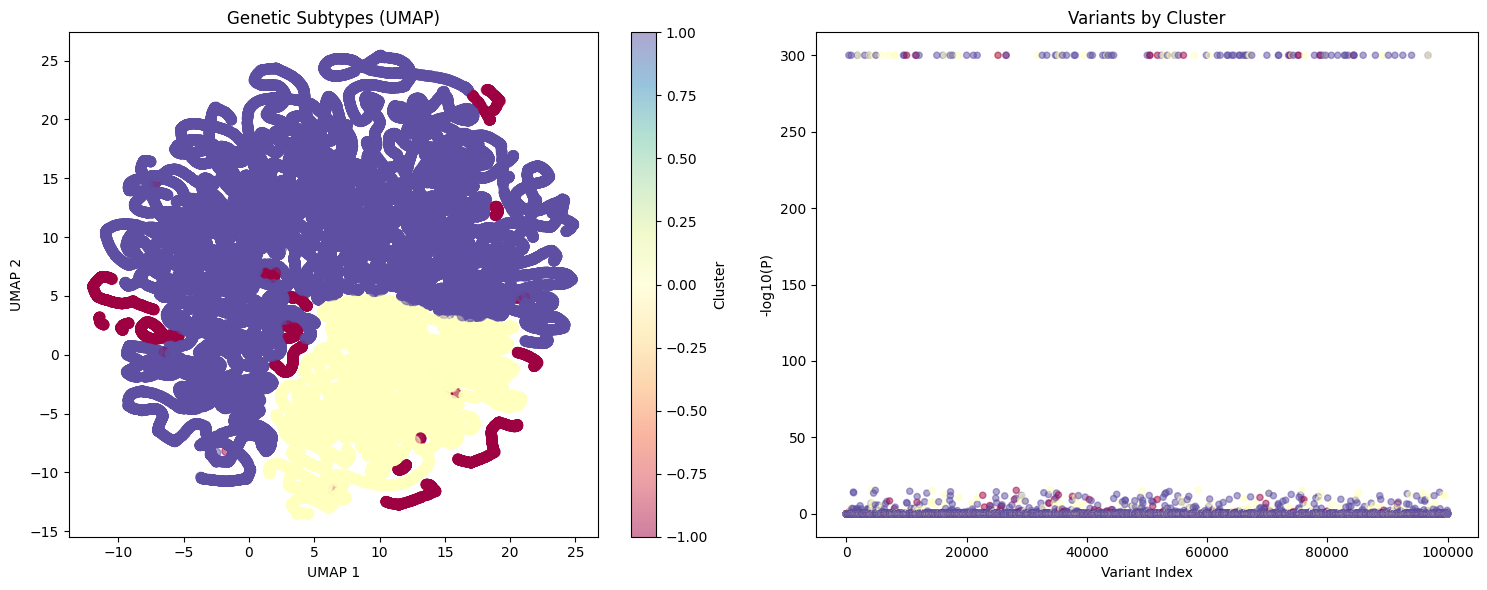

In [9]:
# Create and display visualizations
print("Generating visualizations...")
plot = discoverer.plot_subtypes()
plt.show()